# Face Generation
In this project, we'll use generative adversarial networks to generate new images of faces.
### Get the Data
we'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and we're doing GANs in a project for the first time, we want we to test our neural network on MNIST before CelebA.  Running the GANs on MNIST will allow we to see how well our model trains sooner.

In [1]:
#data_dir = 'E:\\Study_Videos\\Udacity\\Udacity_DeepLearn_Intro_CHANGED\\Projects\\Project_V\\face_generation_sol'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
 
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As we're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. we can view the first number of examples by changing `show_n_images`. 

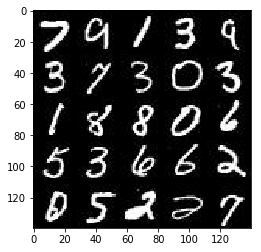

In [2]:
show_n_images = 25

"""
 
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations.  we can view the first number of examples by changing `show_n_images`.

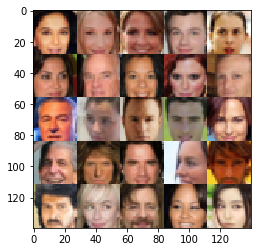

In [3]:
show_n_images = 25

"""
 
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for we.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
we'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure we have the correct version of TensorFlow and access to a GPU

In [4]:
"""
 
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  we are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train our neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    #   Implement Function

    #   Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learn_rate')

    return inputs_real, inputs_z, lr


"""
  THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def Leaky_Relu(x,alpha):
    return tf.maximum(alpha*x,x)

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #   Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x 1/3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        relu1 = Leaky_Relu(x1,0.2)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = Leaky_Relu(bn2,0.2)
        # 7x7x128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)
        return out, logits

"""
  THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
      #   Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = Leaky_Relu(x1,0.2)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = Leaky_Relu(x2,0.2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = Leaky_Relu(x3,0.2)
        # 28x28x128 Now
        
        # Output Layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        # 28x28x3 Now
        
        out = tf.tanh(logits)
        return out



"""
  THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions we implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
     #   Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss




"""
  THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #   Implement Function   
   
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt




"""
  THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help we determine how well the GANs is training.

In [14]:
"""
 
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions we implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while we train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
   #   Build Model
    
    _, width, height, depth = data_shape
    input_real, input_z, learning_rate_ = model_inputs(width, height, depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_, beta1)
    
    saver = tf.train.Saver()
#     sample_z = tf.random_uniform([10, z_dim], -1, 1)
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #   Train Model
                steps += 1
                
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizer
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, depth, data_image_mode)
                    
#         saver.save(sess, './checkpoints/generator.ckpt')
    return losses 

### MNIST
Test our GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.9526... Generator Loss: 0.0945
Epoch 1/2... Discriminator Loss: 2.0453... Generator Loss: 0.3168
Epoch 1/2... Discriminator Loss: 1.4737... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 1.8575... Generator Loss: 0.4965
Epoch 1/2... Discriminator Loss: 1.6812... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 1.5347... Generator Loss: 0.7119
Epoch 1/2... Discriminator Loss: 1.5765... Generator Loss: 0.6357
Epoch 1/2... Discriminator Loss: 1.5193... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 1.5699... Generator Loss: 0.6230
Epoch 1/2... Discriminator Loss: 1.5785... Generator Loss: 0.6172


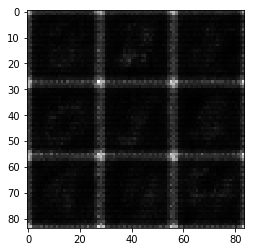

Epoch 1/2... Discriminator Loss: 1.5760... Generator Loss: 0.5591
Epoch 1/2... Discriminator Loss: 1.5558... Generator Loss: 0.5700
Epoch 1/2... Discriminator Loss: 1.5492... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 1.5022... Generator Loss: 0.6028
Epoch 1/2... Discriminator Loss: 1.5252... Generator Loss: 0.5348
Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 0.6284
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.4504... Generator Loss: 0.5990
Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.6105
Epoch 1/2... Discriminator Loss: 1.4150... Generator Loss: 0.6530


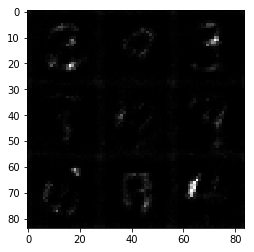

Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.5972
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.6237
Epoch 1/2... Discriminator Loss: 1.4146... Generator Loss: 0.6143
Epoch 1/2... Discriminator Loss: 1.4150... Generator Loss: 0.6101
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.8210
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.9922
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.9260


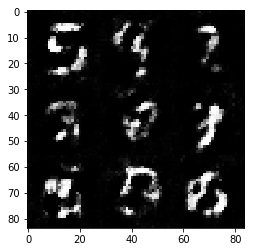

Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 0.9891
Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 1.0112
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.9956
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 1.0840
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 1.0193
Epoch 1/2... Discriminator Loss: 1.2975... Generator Loss: 0.9761
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.9454


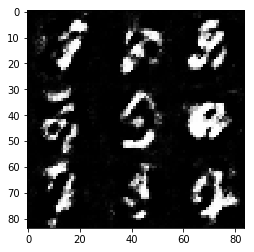

Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 1.1469
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 0.9909
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 0.9726
Epoch 1/2... Discriminator Loss: 1.2534... Generator Loss: 0.9487
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 1.1836
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 1.0273
Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 0.9669
Epoch 2/2... Discriminator Loss: 1.1915... Generator Loss: 0.7379
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 1.2394... Generator Loss: 0.6692


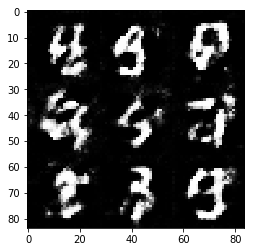

Epoch 2/2... Discriminator Loss: 1.1804... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.7309
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.5965
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 0.7032
Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 0.6773
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 0.7408


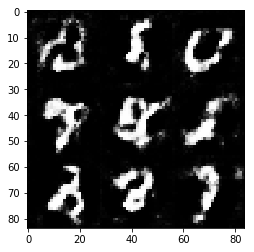

Epoch 2/2... Discriminator Loss: 1.1843... Generator Loss: 0.8729
Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.5974
Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 0.8007
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.5011
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.6326
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.5995


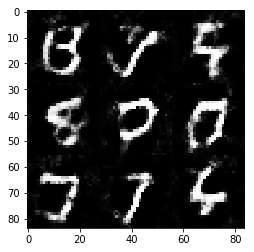

Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.6208
Epoch 2/2... Discriminator Loss: 1.3231... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 1.0950
Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.8847
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 1.0723
Epoch 2/2... Discriminator Loss: 1.3842... Generator Loss: 1.0508
Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.9034
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.9224


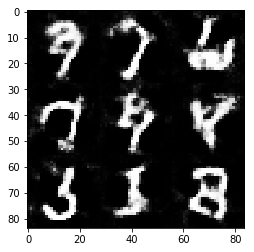

Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.9639
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 1.1319
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.9912
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 0.9182
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 0.9112
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.8150


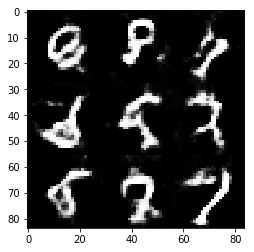

Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 0.5110
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.5643
Epoch 2/2... Discriminator Loss: 1.3703... Generator Loss: 0.6237


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
  THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run our GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  we can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.1073... Generator Loss: 0.0331
Epoch 1/1... Discriminator Loss: 3.5705... Generator Loss: 0.0721
Epoch 1/1... Discriminator Loss: 2.7460... Generator Loss: 0.1719
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.8315... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.7405... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.6983... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.7223... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.9570


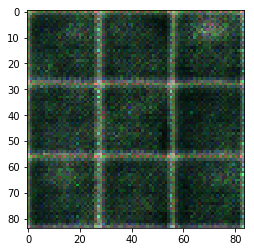

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.6005... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 2.2462
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.8499
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 2.0129
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 2.0809
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 2.0920


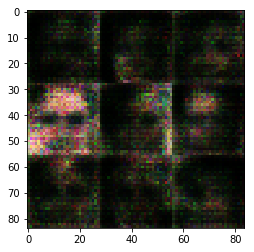

Epoch 1/1... Discriminator Loss: 0.7435... Generator Loss: 2.0322
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.5192
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.6899


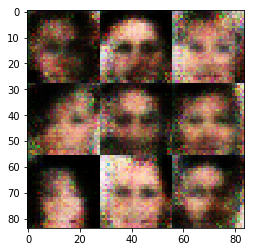

Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 2.2195
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 3.7244
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 1.5922
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 3.1758
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 2.5570
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.5649
Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 3.4979


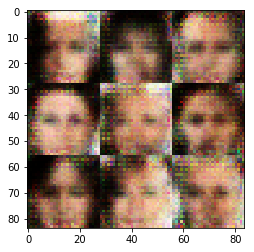

Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 2.7058
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 2.3520
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 2.9342
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.8685
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.8164
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 2.0220
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.6557
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.4779


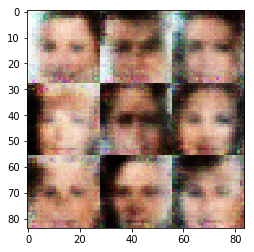

Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 2.4852
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 2.0013
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 2.7001
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 2.0359
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 3.4308
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 1.5684
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5749


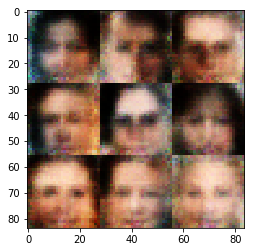

Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.4746
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.7373... Generator Loss: 0.3223
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.9374


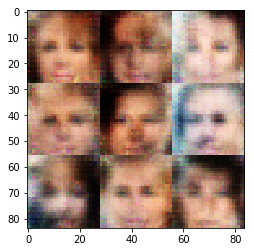

Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.9868
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.9264
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 2.2163
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.3251
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.0844


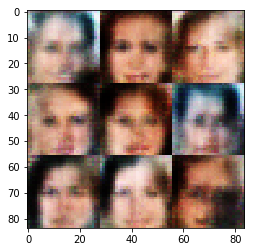

Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.6689
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.7682
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.3671
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.4911
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.6471


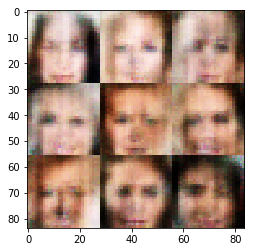

Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.8532... Generator Loss: 0.3119
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.4251
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.5820


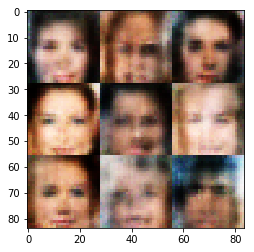

Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 1.3770
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 1.8782
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.8053
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 1.4832
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.5566


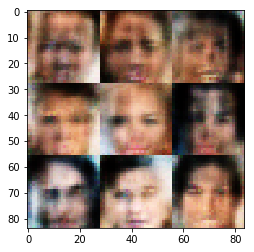

Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.1846
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.2436


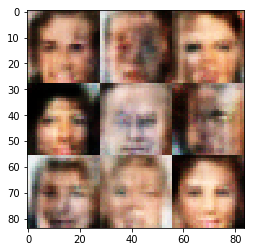

Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.5011
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.6855
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.9225


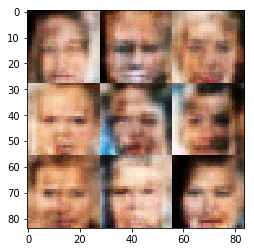

Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 1.3919
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 1.3063
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7168


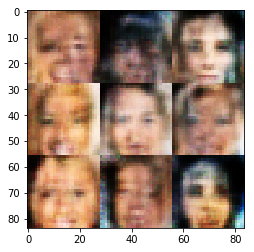

Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.4941
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 1.5042
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.4259
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.7611


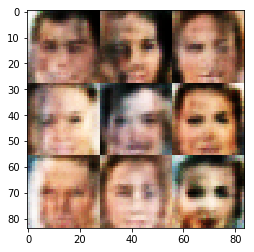

Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.7289
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.4441
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.5610


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = .0001
beta1 = 0.2


"""
  THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)